# Hofova transformacija

Hofova trasformacija se koristi za detekciju linija na slici. Za ulaz imamo sliku nad kojom je izvrsen neki edge detection algoritam, a na izlazu dobicemo matematicke formule pravih koje odgovaraju pravim linijama na slici.

### Kako algoritam radi

Prave se obicno parametrizovane jednacinom oblika y = ax + b. Takva jednacina moze da se zapise kao b = -xa + y sto opet predstavlja jednacinu prave ali u prostoru (a,b) gde su x i y parametri. Za sve $x_{i}$ i $y_{i}$ koje zadovoljavaju $y_{i}$ = a$x_{i}$ + b, prave b = -$x_{i}$a + $y_{i}$ ce imati jedan zajednicki presek u tacki a, b koja zapravo predstavlja parametre a i b u datim jednacinama. Akumulatorskom matricom mozemo lako naci tu tacku. Ona predstavlja matricu sa pocetnim vrednostima 0 na svakom polju na koju se dodaju jednacine prave tako sto se za svako polje kroz koju prava prolazi dodaje 1, tako da ce polje koje predstavlja presek svih pravih imati najvecu vrednost na kraju. Algoritam radi tako sto za svaki piksel koordinata $x_{i}$ i $y_{i}$ koji predstavlja ivicu na pocetnoj slici azurira akumulatorsku matricu sa jednacinom b = -$x_{i}$a + $y_{i}$. Polja matrice sa najvecim vrednostima ce biti parametri trazenih jednacina.

Problem sa parametrizacijom y = ax + b je to sto ne mogu da se prikazu vertikalne linije i sto su vrednosti b neogranicene.  Zato se koristi druga parametrizacija $\rho$=xcos$\theta$+ysin$\theta$. $\theta$ je ograniceno sa -$\pi$ i $\pi$ a $\rho$ velicinom slike. Na isti nacin se izvrasava algoritam samo sa drugom parametrizacijom.

In [7]:
import numpy as np
import math
from skimage.draw import line
from skimage.transform import hough_line_peaks

import matplotlib.pyplot as plt
from matplotlib import cm

In [8]:
def hough_line(img):
    # Ogranicenja za ro i teta
    thetas = np.deg2rad(np.arange(-90.0, 90.0, 1))
    width, height = img.shape
    diag_len = int(round(math.sqrt(width * width + height * height)))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Inicijalizacija akumulatorske matrice
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint8)
    # Pamcenje piksela ivica
    y_idxs, x_idxs = np.nonzero(img > 5)

    # Prolazak kroz sve piksele ivica
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(num_thetas):
            # Azuriranje akumulatora
            rho = diag_len + int(round(x * cos_t[t_idx] + y * sin_t[t_idx]))
            accumulator[rho, t_idx] += 1

    return accumulator, thetas, rhos

def show_hough_line(img, accumulator, thetas, rhos):
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    ax = axes.ravel()
    ax[0].imshow(image, cmap=cm.gray)
    ax[0].set_title('Input image')

    angle_step = 0.5 * np.diff(thetas).mean()
    rho_step = 0.5 * np.diff(rhos).mean()
    bounds = [np.rad2deg(thetas[0] - angle_step),
              np.rad2deg(thetas[-1] + angle_step),
              rhos[-1] + rho_step, rhos[0] - rho_step]
    ax[1].imshow(np.log(1 + accumulator), extent=bounds, cmap=cm.gray, aspect=1 / 1.5)
    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distance (pixels)')
    ax[1].axis('image')

    ax[2].imshow(image, cmap=cm.gray)
    ax[2].set_ylim((image.shape[0], 0))
    ax[2].set_title('Detected lines')

    for _, angle, dist in zip(*hough_line_peaks(accumulator, thetas, rhos)):
        (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
        ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2))

    plt.tight_layout()
    plt.show()

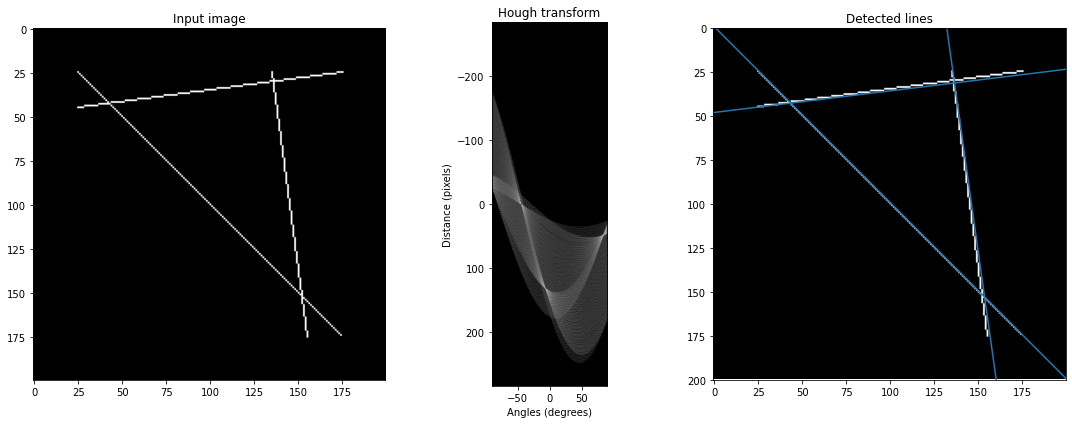

In [9]:
image = np.zeros((200, 200))
idx = np.arange(25, 175)
image[idx, idx] = 255
image[line(45, 25, 25, 175)] = 255
image[line(25, 135, 175, 155)] = 255

accumulator, thetas, rhos = hough_line(image)
show_hough_line(image, accumulator, thetas, rhos)

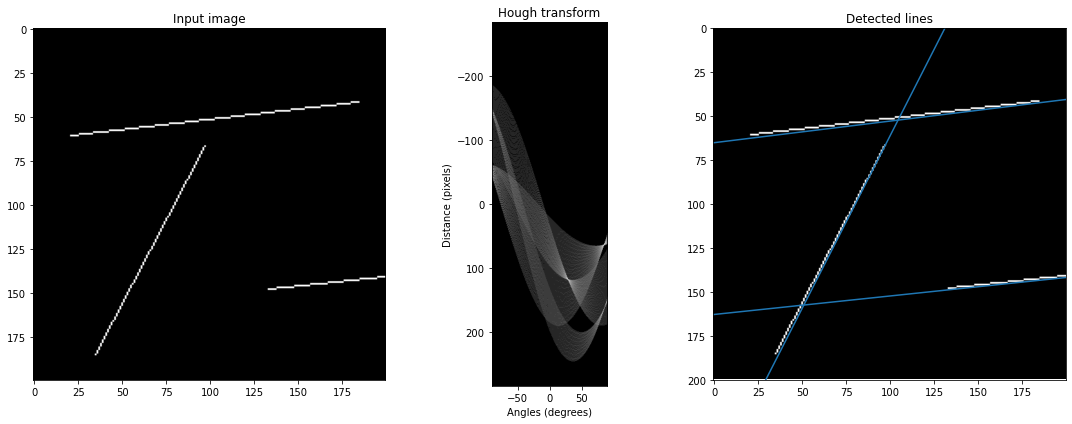

In [13]:
image = np.zeros((200, 200))
idx = np.arange(25, 175)
image[line(*tuple(np.random.randint(0, 200, 4)))] = 255
image[line(*tuple(np.random.randint(0, 200, 4)))] = 255
image[line(*tuple(np.random.randint(0, 200, 4)))] = 255

accumulator, thetas, rhos = hough_line(image)
show_hough_line(image, accumulator, thetas, rhos)